In [17]:
# Importing required libraries
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
# Function to load and preprocess images
def load_and_preprocess_images(category_directory, class_label, s=150):
    dataset = []
    label = []
    for filename in os.listdir(category_directory):
        img_path = os.path.join(category_directory, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (s, s))
            img = img.astype(np.float32) / 255.0
            dataset.append(img)
            label.append(class_label)
    return dataset, label

In [33]:
# Defining categories and loading data
categories = ['Uveitis', 'Normal_Eyee']
dataset, label = [], []

for idx, category in enumerate(categories):
    data, labels = load_and_preprocess_images(category, idx)
    dataset.extend(data)
    label.extend(labels)


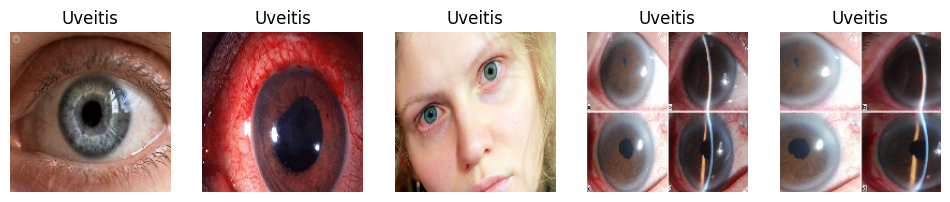

In [34]:
import matplotlib.pyplot as plt

# Function to display sample images from the dataset
def display_samples(dataset, label, categories, num_samples=5):
    plt.figure(figsize=(12, 6))  # Set the figure size
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)  # Create subplots to display multiple images
        plt.imshow(dataset[i])  # Display the image
        plt.title(categories[label[i]])  # Set title to the category name
        plt.axis('off')  # Hide axes

    plt.show()

# Call the function to display 5 sample images from the dataset
display_samples(dataset, label, categories, num_samples=5)

In [20]:
# Convert to numpy arrays
dataset = np.array(dataset)
label = np.array(label)

# Display the shape of the dataset
print("Dataset shape:", dataset.shape)
print("Label shape:", label.shape)

Dataset shape: (601, 150, 150, 3)
Label shape: (601,)


In [21]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, stratify=label, random_state=43)

# One-hot encoding the labels
num_classes = len(categories)
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

In [22]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Fine-tune the top layers
for layer in base_model.layers[-4:]:
    layer.trainable = True

In [23]:
# Define learning rate scheduler
def lr_scheduler(epoch):
    if epoch < 10:
        return 0.0001
    else:
        return 0.0001 * np.exp(0.1 * (10 - epoch))

lr_schedule = LearningRateScheduler(lr_scheduler)


In [24]:
# Define the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Show model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 15763650 (60.13 MB)
Trainable params: 8128386 (31.01 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


In [25]:
# Data augmentation for the training set
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [26]:
# Defining callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train_one_hot, batch_size=32),
    epochs=20,
    validation_data=(X_test, y_test_one_hot),
    callbacks=[early_stop, checkpoint, lr_schedule]
)

Epoch 1/20


15/15 [==============================] - ETA: 0s - loss: 0.6858 - accuracy: 0.6500

F:\anconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - 44s 3s/step - loss: 0.6858 - accuracy: 0.6500 - val_loss: 0.3893 - val_accuracy: 0.8264 - lr: 1.0000e-04
Epoch 2/20
15/15 [==============================] - 36s 2s/step - loss: 0.4474 - accuracy: 0.8000 - val_loss: 0.3392 - val_accuracy: 0.8182 - lr: 1.0000e-04
Epoch 3/20
15/15 [==============================] - 36s 2s/step - loss: 0.3385 - accuracy: 0.8562 - val_loss: 0.2819 - val_accuracy: 0.8760 - lr: 1.0000e-04
Epoch 4/20
15/15 [==============================] - 38s 3s/step - loss: 0.2630 - accuracy: 0.8854 - val_loss: 0.2547 - val_accuracy: 0.9008 - lr: 1.0000e-04
Epoch 5/20
15/15 [==============================] - 33s 2s/step - loss: 0.2527 - accuracy: 0.8979 - val_loss: 0.2869 - val_accuracy: 0.9008 - lr: 1.0000e-04
Epoch 6/20
15/15 [==============================] - 36s 2s/step - loss: 0.2260 - accuracy: 0.9104 - val_loss: 0.1907 - val_accuracy: 0.8926 - lr: 1.0000e-04
Epoch 7/20
15/15 [==============================] - 34s 2s/step - los

In [27]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_one_hot)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Predict class probabilities for the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Evaluation metrics
evaluation_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, average='weighted'),
    'Recall': recall_score(y_test, y_pred, average='weighted'),
    'F1 Score': f1_score(y_test, y_pred, average='weighted')
}

for metric, value in evaluation_metrics.items():
    print(f'{metric}: {value}')

4/4 [==============================] - 5s 1s/step - loss: 0.2330 - accuracy: 0.9256
Loss: 0.2330433577299118, Accuracy: 0.9256198406219482
4/4 [==============================] - 6s 1s/step
Accuracy: 0.9256198347107438
Precision: 0.9261031366294524
Recall: 0.9256198347107438
F1 Score: 0.9257946283722887


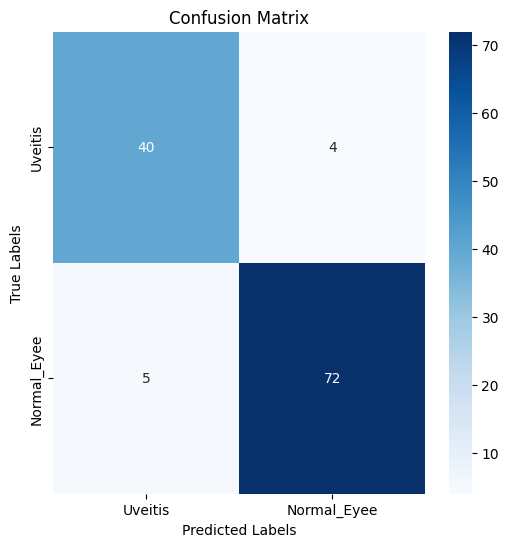

In [28]:
# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='.0f', xticklabels=categories, yticklabels=categories, cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

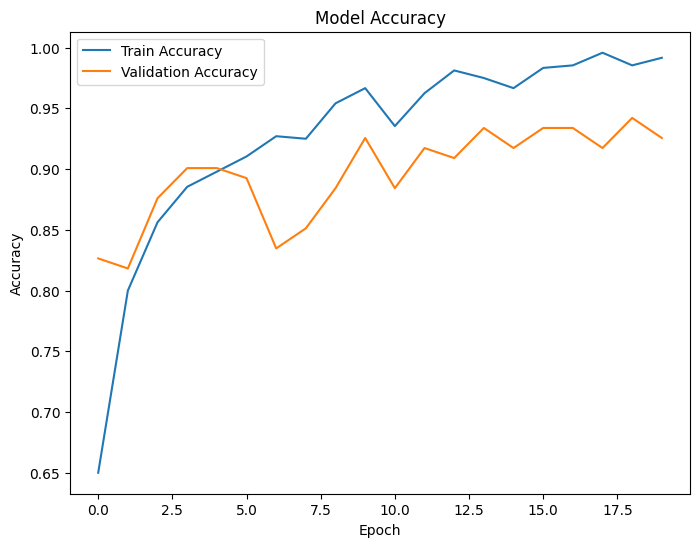

In [29]:
# Plot training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


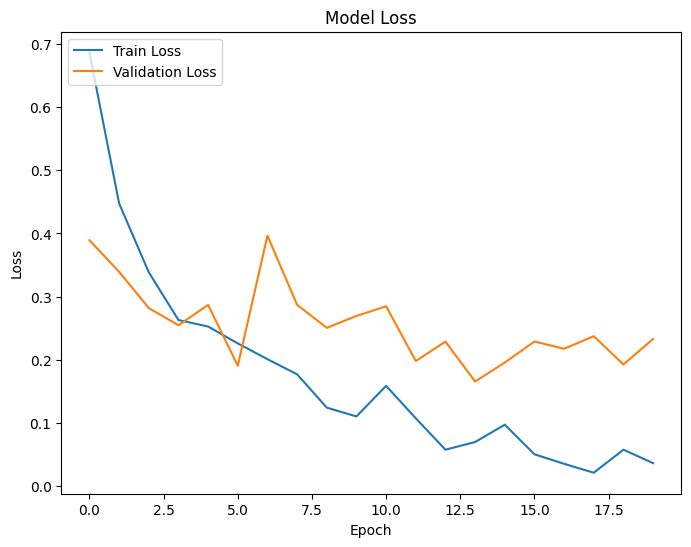

In [30]:
# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [31]:
# Save the trained model and its architecture
model.save('Eye.h5', include_optimizer=False)
print("Model saved as 'Eye.h5'")

model_json = model.to_json()
with open("Eye.json", "w") as json_file:
    json_file.write(model_json)
print("Saved model architecture to 'Eye.json'")

Model saved as 'Eye.h5'
Saved model architecture to 'Eye.json'


F:\anconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
